# **Проект анализа стилометрических характеристик текстов**

Проект включает: парсинг, предобработку и анализа текстовых данных (стилометрических характеристик) на примере писем и дневниковых записей А.С. Суворина.

## **1. Сбор и создание корпуса текстов**

Исходные данные:

Корпус текстов был собран из книги:

Суворин А.C. Русско-японская война и русская революция. Маленькие письма (1904–1908). М. : Алгоритм, 2005. 720 с.

*  Книга содержит 280 писем с номерами от CDLI (451) до DCCXXX (730), написанных в период с 12 (25) января 1904 г. по 28 августа (10 сентября) 1908 г.

Тексты были извлечены с веб-сайта электронной библиотеки fb2.top: https://fb2.top/russko-yaponskaya-voyna-i-russkaya-revolyuciya-malenykie-pisyma-1904-ndash-1908-543596/read/part-1.

# Реализация:

Идентификация структуры данных на веб-странице:


*   Каждая страница соответствует письмам одного года.
*   Письма находятся внутри HTML-тегов.

Автоматизация парсинга:

*   Использовалась библиотека BeautifulSoup для извлечения текстов писем, их ID, дат и других характеристик.
*   Был настроен запрос к страницам сайта с использованием библиотеки requests.

Сохранение данных:

*   Для каждого письма создается отдельный текстовый файл.
*   Все письма одного года объединяются в общий текстовый файл.

Создание структуры данных:

*   Для каждого года создается отдельная директория (1904, 1905, …), в которой хранятся письма в формате .txt.

Цель этапа:

Собранный корпус текстов необходим для дальнейшего анализа с использованием методов стилометрии. Он содержит уникальные исторические данные, разделенные по годам, что позволяет анализировать тексты в динамике.
  



---


*Для корректной работы кода проверьте установку всех необходимых библиотек,
см. комментарий по использованию библиотек, также необходимо импортировать в корневой каталог среды Google Colab файл suworin_a_s-text_1912_pisma_k_rozanovu.fb2*



---



### Комментарии по использованию библиотек:
1. os: Работа с файлами и директориями (например, чтение текстов из папки).
2. re: Регулярные выражения для очистки текста.
3. csv: Экспорт и чтение данных в формате CSV.
4. Counter: Подсчет частот слов, биграмм и т.п.
5. numpy: Вычисление статистических метрик (например, Z-оценок).
6. matplotlib.pyplot: Построение диаграмм для визуализации результатов.
7. requests: Загрузка веб-страниц для парсинга.
8. BeautifulSoup: Извлечение информации из HTML или XML.
9. tqdm: Отображение прогресс-бара для циклов обработки.
10. nltk: Работа с текстами (токенизация, стоп-слова, коллокации и др.).
11. pymorphy3: Лемматизация и морфологический анализ русскоязычного текста.

In [14]:
!pip install requests beautifulsoup4 tqdm

In [15]:
!pip install pymorphy3

In [16]:
# Импорт необходимых библиотек

import os  # Работа с файловой системой
import re  # Регулярные выражения для поиска и замены текста
import csv  # Работа с CSV-файлами
from collections import Counter  # Подсчет частот слов, биграмм и других элементов
import numpy as np  # Математические операции (среднее, стандартное отклонение и т.д.)

# Импорт библиотек для визуализации
import matplotlib.pyplot as plt  # Построение графиков и визуализаций

# Импорт библиотек для веб-парсинга
import requests  # HTTP-запросы (например, загрузка страниц)
from bs4 import BeautifulSoup  # Парсинг HTML/XML
from tqdm import tqdm  # Прогресс-бар для обработки данных

# Импорт библиотеки NLTK для обработки текста
import nltk  # Библиотека для обработки естественного языка
from nltk import word_tokenize, sent_tokenize  # Токенизация текста (слова и предложения)
from nltk.corpus import stopwords  # Стоп-слова
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures  # Нахождение биграмм

# Импорт библиотеки pymorphy3 для морфологического анализа русского языка
from pymorphy3 import MorphAnalyzer  # Лемматизация и анализ слов

# Загрузка данных для NLTK
# "punkt" используется для токенизации текста на предложения
# "stopwords" содержит списки стоп-слов для различных языков
nltk.download('punkt')  # Токенизация предложений
nltk.download('stopwords')  # Загрузка стоп-слов для различных языков
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Модуль 1 - Парсинг
# URL для парсинга
BASE_URL = "https://fb2.top/russko-yaponskaya-voyna-i-russkaya-revolyuciya-malenykie-pisyma-1904-ndash-1908-543596/read/part-"

# Годы и страницы (каждому году соответствует номер страницы)
YEARS = [1904, 1905, 1906, 1907, 1908]
PAGES = [2, 3, 4, 5, 6]

# Заголовки для маскировки запроса
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.5481.104 Safari/537.36"
}

# Функция для создания директорий по годам
def create_directories(years):
    """
    Создает директории для каждого года из списка years, если они еще не существуют.
    """
    for year in years:
        os.makedirs(str(year), exist_ok=True)  # Создание директории с именем года

# Функция для парсинга страницы
def parse_page(url, year):
    """
    Выполняет парсинг заданной страницы и извлекает данные писем.

    Аргументы:
    - url: Ссылка на страницу для парсинга.
    - year: Год, к которому относится страница.

    Возвращает:
    - Список писем, каждое из которых содержит ID, текст письма и информацию о дате и номере выпуска.
    """
    # Отправляем HTTP-запрос
    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print(f"Ошибка {response.status_code} при доступе к {url}")
        return []  # Возвращаем пустой список, если запрос завершился ошибкой

    # Анализ HTML-кода страницы
    soup = BeautifulSoup(response.text, "html.parser")

    # Список для хранения писем
    letters = []

    # Парсинг всех фрагментов с письмами
    for section in soup.find_all("section"):
        # Поиск ID письма в <h3> (внутри <span>)
        header = section.find("h3", id=True)
        if not header:
            continue  # Пропускаем без <h3>

        # Получение ID письма
        letter_id = header.find("span").get_text(strip=True) if header.find("span") else "UnknownID"

        # Извлечение текста письма
        text_blocks = section.find_all("p")
        if len(text_blocks) < 2:
            continue  # Пропускаем письма, если в них недостаточно текстовых блоков
        letter_text = "\n".join([p.get_text(strip=True) for p in text_blocks[:-1]])  # Все абзацы, кроме последнего
        footer = text_blocks[-1].get_text(strip=True)  # Последний <p> содержит дату и номер выпуска

        # Добавление письма в список
        letters.append({
            "id": letter_id,
            "text": letter_text,
            "footer": footer
        })

    return letters  # Возвращаем список писем

# Функция для записи писем в файлы
def save_letters(letters, year):
    """
    Сохраняет письма в отдельные файлы и объединенный файл для каждого года.
    - letters: Список писем, каждое письмо в формате словаря с ключами "id", "text", "footer".
    - year: Год, к которому относятся письма.
    """
    combined_text = ""  # Переменная для объединенного текста всех писем года

    # Проходим по каждому письму
    for letter in letters:
        # Безопасное имя файла (удаляем запрещенные символы и ограничиваем длину имени)
        safe_id = "".join([c for c in letter['id'] if c.isalnum() or c in (" ", "_", "-")]).strip()
        safe_id = safe_id[:50]  # Ограничение длины имени файла
        filename = f"{year}/{safe_id}.txt"  # Путь к файлу

        # Сохранение письма в отдельный файл
        with open(filename, "w", encoding="utf-8") as f:
            f.write(f"ID письма: {letter['id']}\n")
            f.write(f"Дата и номер выпуска: {letter['footer']}\n")
            f.write("\nТекст письма:\n")
            f.write(letter["text"])

        # Добавляем письмо в объединенный текст
        combined_text += f"ID письма: {letter['id']}\n"
        combined_text += f"Дата и номер выпуска: {letter['footer']}\n"
        combined_text += "\nТекст письма:\n"
        combined_text += letter["text"] + "\n\n"

    # Сохранение объединенного файла
    with open(f"{year}.txt", "w", encoding="utf-8") as f:
        f.write(combined_text)

# Основная функция для выполнения парсинга
def main2():
    """
    Основная функция. Выполняет создание директорий, парсинг страниц и сохранение данных.
    """
    create_directories(YEARS)  # Создаем директории для каждого года

    for year, page in zip(YEARS, PAGES):  # Проходим по каждому году и номеру страницы
        print(f"Парсинг писем за {year} год...")
        url = f"{BASE_URL}{page}"  # Формируем URL для текущей страницы
        letters = parse_page(url, year)  # Парсим страницу
        if letters:  # Если письма найдены, сохраняем их
            save_letters(letters, year)
        time.sleep(2)  # Задержка между запросами для предотвращения блокировки

    print("Парсинг завершен")

# Запуск скрипта
if __name__ == "__main__":
    main2()

Парсинг писем за 1904 год...
Парсинг писем за 1905 год...
Парсинг писем за 1906 год...
Парсинг писем за 1907 год...
Парсинг писем за 1908 год...
Парсинг завершен



# 2. Очистка текстов, выделение n-грамм и вычисление коллокаций

### Очистка текста:

* Удаление стоп-слов, пунктуации и лишних символов.

* Разделение текста на предложения и слова.

* Выделение n-грамм (по умолчанию биграмм).

Вычисление топовых коллокаций с использованием метрики PMI.

### Вывод результатов:

* Очищенные предложения.

* Частотность n-грамм.

* Метрики коллокаций.

### Сохранение:

* Результаты сохраняются в текстовых и CSV-файлах для каждого входного текста.

In [19]:
# Коллокации, подсчет n-грамм
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
# Инициализация морфологического анализатора и загрузка стоп-слов
morph = MorphAnalyzer()
nltk_stops = stopwords.words('russian')
custom_stops = {"это", "весь", "который", "такой", "свой", "наш", "письма", "дата", "текст", "номер", "выпуск"}
stops = set(nltk_stops).union(custom_stops)

# Шаблоны для удаления
additional_patterns = [
    r'письмо\s+дата', r'дата\s+номер',r'письмо\s+выпуск', r'номер\s+выпуск', r'текст\s+письмо', r'дата\s+(\w+)',
    r'который', r'это', r'такой', r'свой', r'наш', 'письма', 'выпуска'
]

# Функция для очистки текста по заданныхм шаблонам
def remove_patterns1(text, patterns):
    for pattern in patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    return text

# Функция для предобработки текста
def preprocess_text1(text):
    # Приведение к нижнему регистру и токенизация
    tokens = word_tokenize(text.lower())
    # Удаление пунктуации, стоп-слов и коротких слов
    tokens = [re.sub(r'\W+', '', token) for token in tokens if len(token) > 2]
    tokens = [token for token in tokens if token not in stops]

    # Лемматизация
    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return tokens

# Функция для извлечения n-грамм
def extract_ngrams(tokens, n=2):
    return list(zip(*[tokens[i:] for i in range(n)]))

# Функция для вычисления коллокаций
def compute_collocations(tokens, n=2, top_n=15):
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    top_collocations = finder.nbest(bigram_measures.pmi, top_n)  # Топ по метрике PMI
    scores = finder.score_ngrams(bigram_measures.pmi)  # Все биграммы с метриками
    return top_collocations, scores

# Основная функция для обработки одного файла
def process_file(file_path):
    # Try reading with 'utf-8', fallback to 'windows-1251' if it fails
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='windows-1251') as file:
            text = file.read()

    # Очистка текста
    text = re.sub(r'\n', ' ', text)  # Удаление переводов строк
    text = re.sub(r'[a-zA-Z…]', '', text)  # Удаление латинских символов
    text = re.sub(r'\d+', '', text)  # Удаление чисел

    # Разбиение на предложения
    sentences = sent_tokenize(text)

    # Очистка и лемматизация предложений
    clean_sentences = [' '.join(preprocess_text1(sent)) for sent in sentences]

    # Извлечение токенов
    tokens = []
    for sent in clean_sentences:
        tokens.extend(word_tokenize(sent))

    # Подсчет n-грамм
    ngram_counter = Counter(extract_ngrams(tokens, n=2))

    # Вычисление коллокаций
    top_collocations, collocation_scores = compute_collocations(tokens, n=2)

    return {
        "clean_sentences": clean_sentences,
        "tokens": tokens,
        "ngram_counter": ngram_counter,
        "top_collocations": top_collocations,
        "collocation_scores": collocation_scores
    }

# Сохранение результатов в файлы
def save_results(file_name, results, output_dir="output"):
    os.makedirs(output_dir, exist_ok=True)

    # Сохранение очищенных предложений
    with open(os.path.join(output_dir, f"{file_name}_sentences.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(results["clean_sentences"]))

    # Сохранение n-грамм
    with open(os.path.join(output_dir, f"{file_name}_ngrams.csv"), "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["N-gram", "Frequency"])
        for ngram, count in results["ngram_counter"].items():
            writer.writerow([" ".join(ngram), count])

    # Сохранение топовых коллокаций
    with open(os.path.join(output_dir, f"{file_name}_top_collocations.csv"), "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Collocation", "PMI Score"])
        for collocation, score in results["collocation_scores"]:
            writer.writerow([" ".join(collocation), score])

# Основная функция для обработки всех файлов
def main1(input_dir=".", output_dir="output"):
    files = [file for file in os.listdir(input_dir) if file.endswith(".txt")]
    for file in files:
        print(f"Обработка файла {file}...")
        results = process_file(os.path.join(input_dir, file))
        save_results(file.split(".")[0], results, output_dir=output_dir)
    print("Обработка завершена")

if __name__ == "__main__":
    main1(input_dir=".", output_dir="output_col")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Обработка файла 1905.txt...
Обработка файла 1907.txt...
Обработка файла 1908.txt...
Обработка файла 1904.txt...
Обработка файла 1906.txt...
Обработка завершена


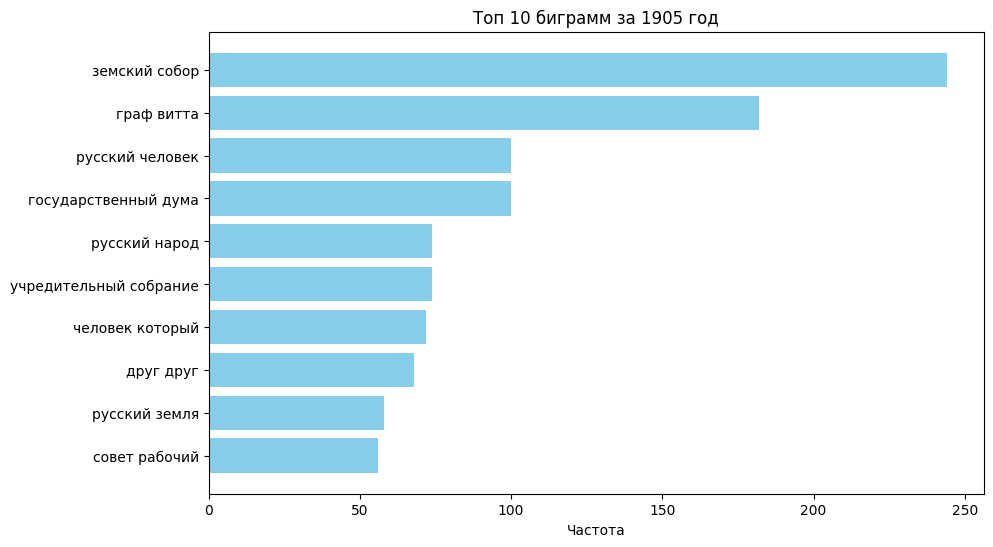

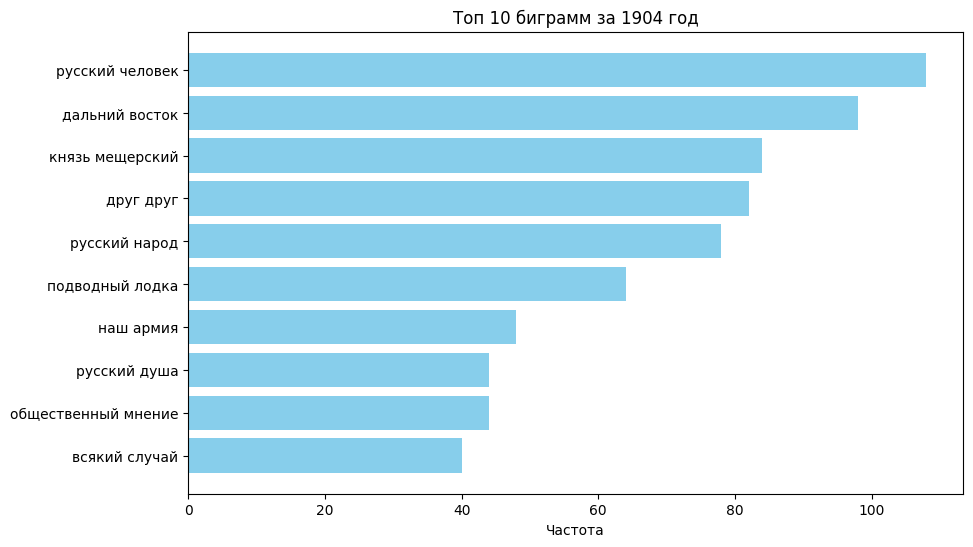

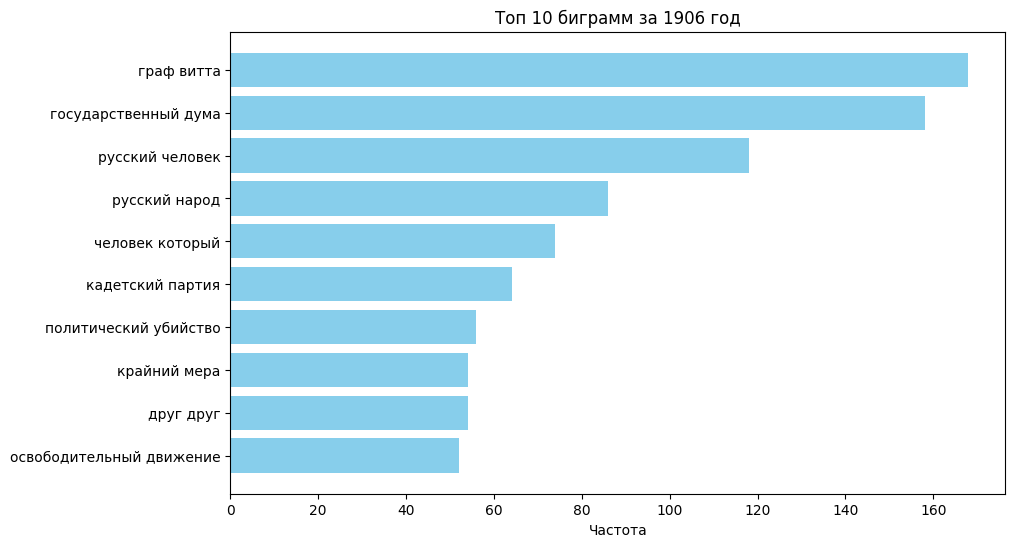

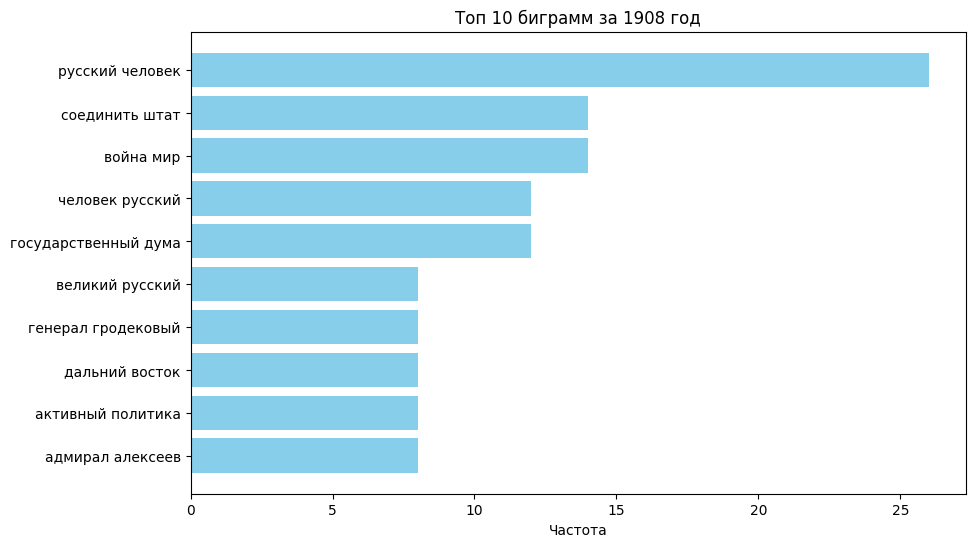

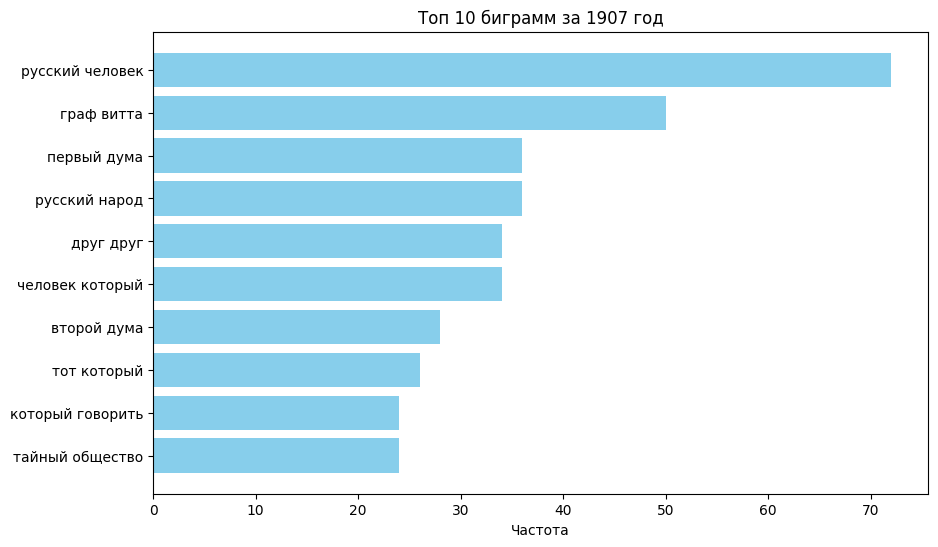

In [20]:
# Визуализация частотных биграмм
import matplotlib.pyplot as plt
import pandas as pd

def visualize_bigrams_by_year(input_dir):
    files = [file for file in os.listdir(input_dir) if file.endswith("_ngrams.csv")]
    for file in files:
        year = file.split("_")[0]
        file_path = os.path.join(input_dir, file)

        # Чтение данных
        df = pd.read_csv(file_path)
        df = df.sort_values(by="Frequency", ascending=False).head(10)

        # Построение графика
        plt.figure(figsize=(10, 6))
        plt.barh(df["N-gram"], df["Frequency"], color='skyblue')
        plt.xlabel("Частота")
        plt.title(f"Топ 10 биграмм за {year} год")
        plt.gca().invert_yaxis()
        plt.show()

visualize_bigrams_by_year("output_col")

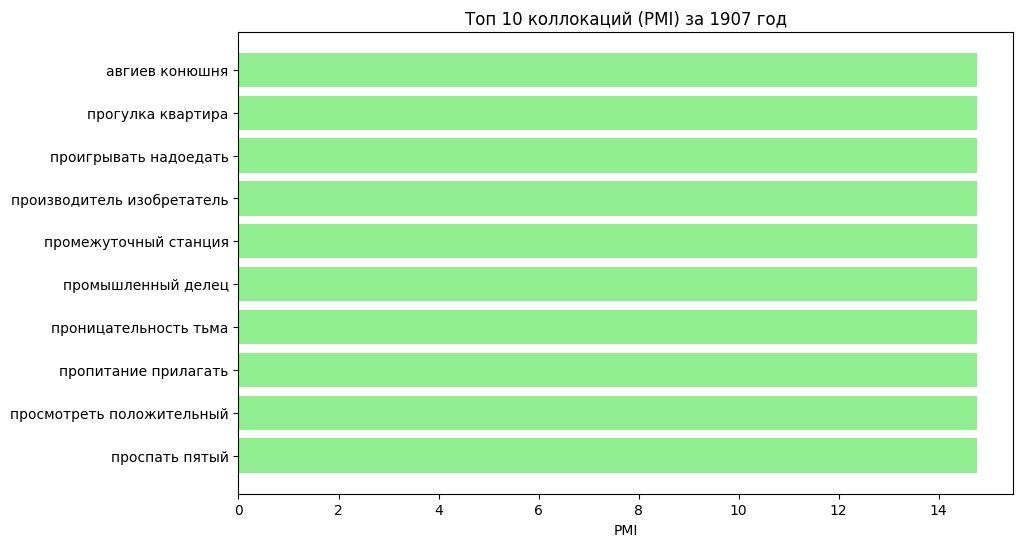

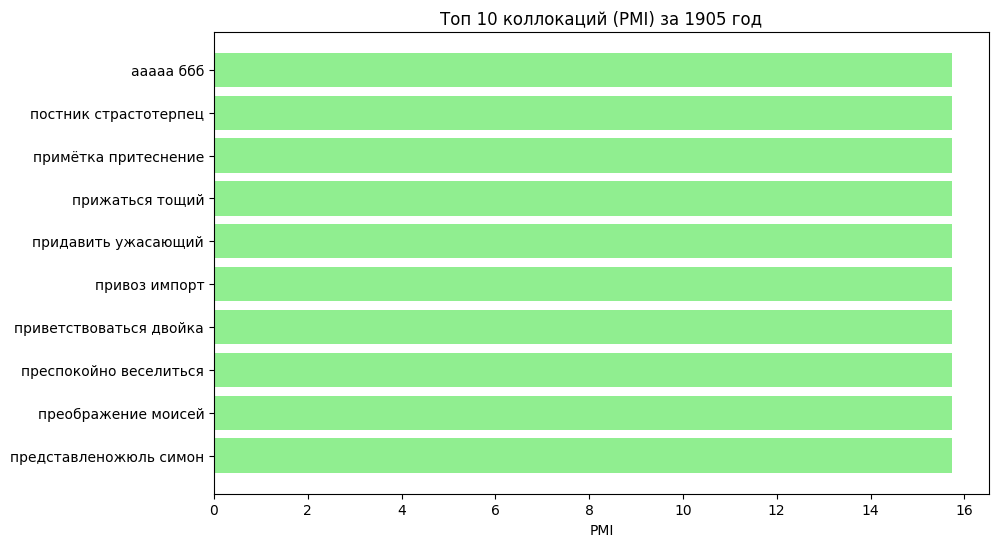

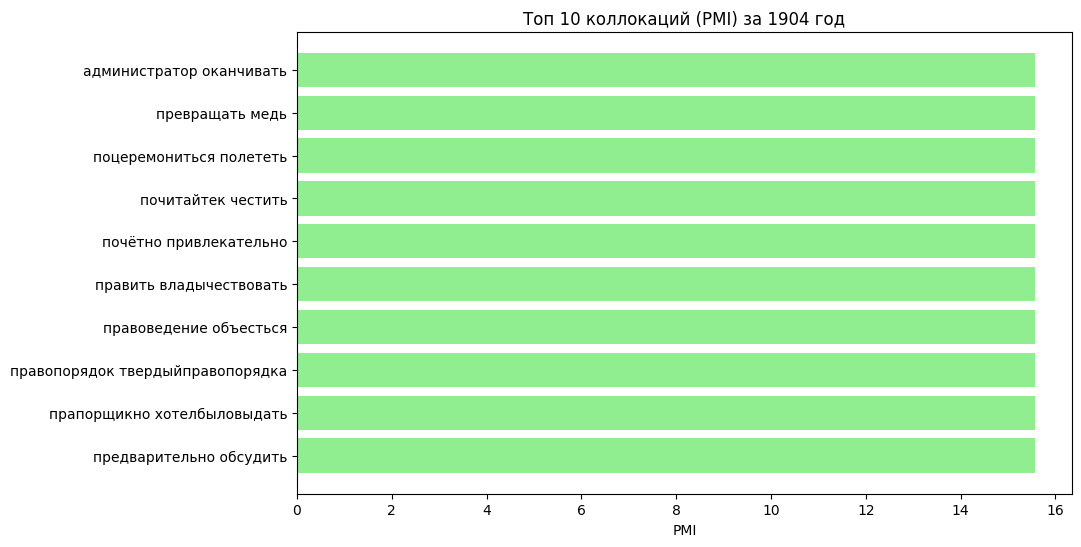

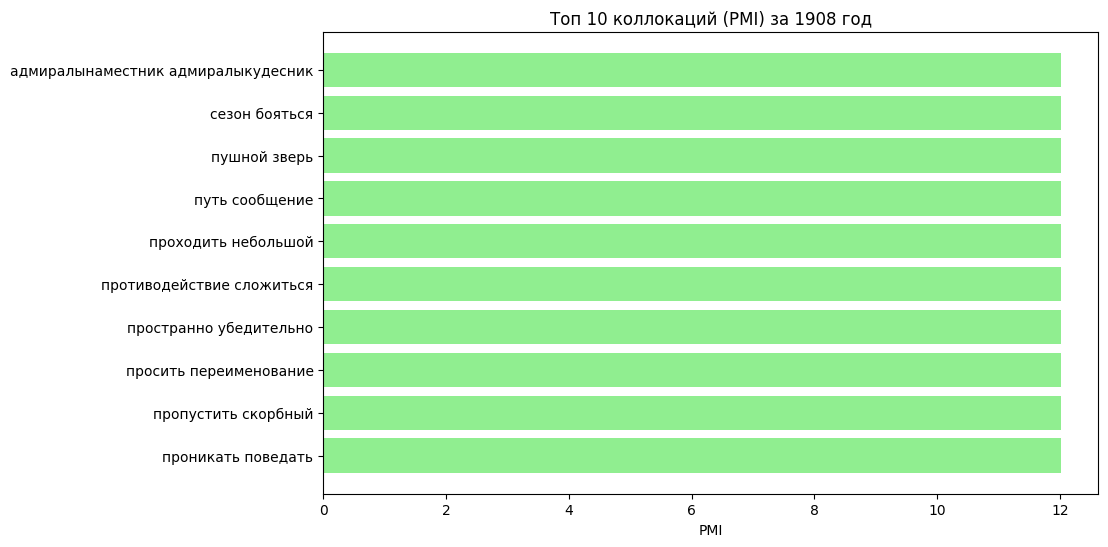

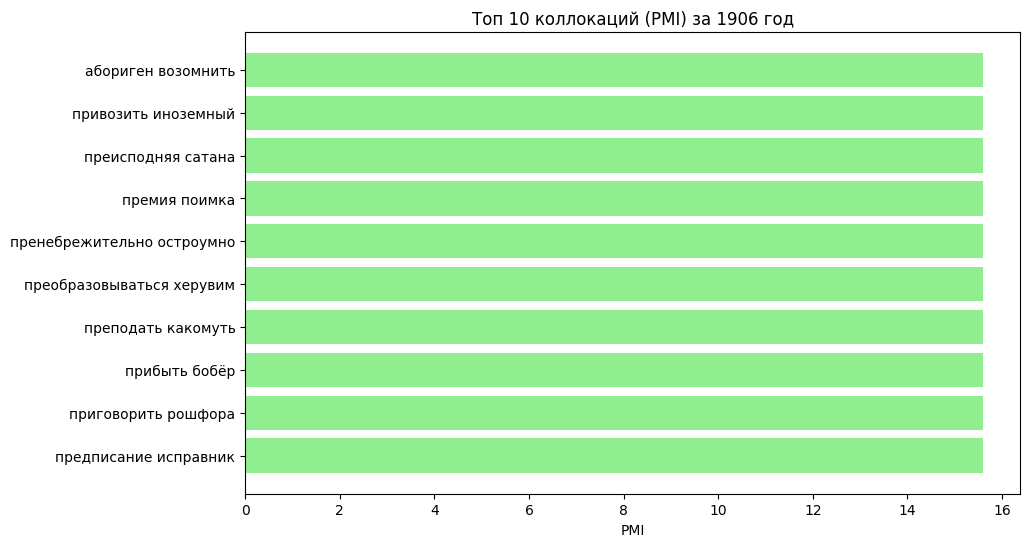

In [21]:
# Визуализация PMI коллокаций
def visualize_pmi_by_year(input_dir):
    files = [file for file in os.listdir(input_dir) if file.endswith("_top_collocations.csv")]
    for file in files:
        year = file.split("_")[0]
        file_path = os.path.join(input_dir, file)

        # Чтение данных
        df = pd.read_csv(file_path)
        df = df.sort_values(by="PMI Score", ascending=False).head(10)

        # Построение графика
        plt.figure(figsize=(10, 6))
        plt.barh(df["Collocation"], df["PMI Score"], color='lightgreen')
        plt.xlabel("PMI")
        plt.title(f"Топ 10 коллокаций (PMI) за {year} год")
        plt.gca().invert_yaxis()
        plt.show()

visualize_pmi_by_year("output_col")

Топ-10 слов за 1904 год:
   русский: 928 раз
   мочь: 916 раз
   россия: 758 раз
   человек: 626 раз
   война: 572 раз
   дело: 544 раз
   время: 440 раз
   флот: 398 раз
   должный: 366 раз
   ещё: 360 раз
----------------------------------------
Топ-10 слов за 1905 год:
   мочь: 1026 раз
   русский: 916 раз
   человек: 822 раз
   россия: 796 раз
   правительство: 648 раз
   мир: 524 раз
   народ: 502 раз
   революция: 464 раз
   время: 450 раз
   знать: 446 раз
----------------------------------------
Топ-10 слов за 1906 год:
   русский: 1032 раз
   человек: 1012 раз
   дума: 930 раз
   мочь: 794 раз
   правительство: 512 раз
   россия: 496 раз
   революция: 450 раз
   партия: 440 раз
   сказать: 428 раз
   дело: 384 раз
----------------------------------------
Топ-10 слов за 1907 год:
   дума: 562 раз
   русский: 536 раз
   мочь: 498 раз
   человек: 430 раз
   сказать: 242 раз
   россия: 234 раз
   партия: 216 раз
   революция: 212 раз
   министр: 210 раз
   дело: 202 раз
----------

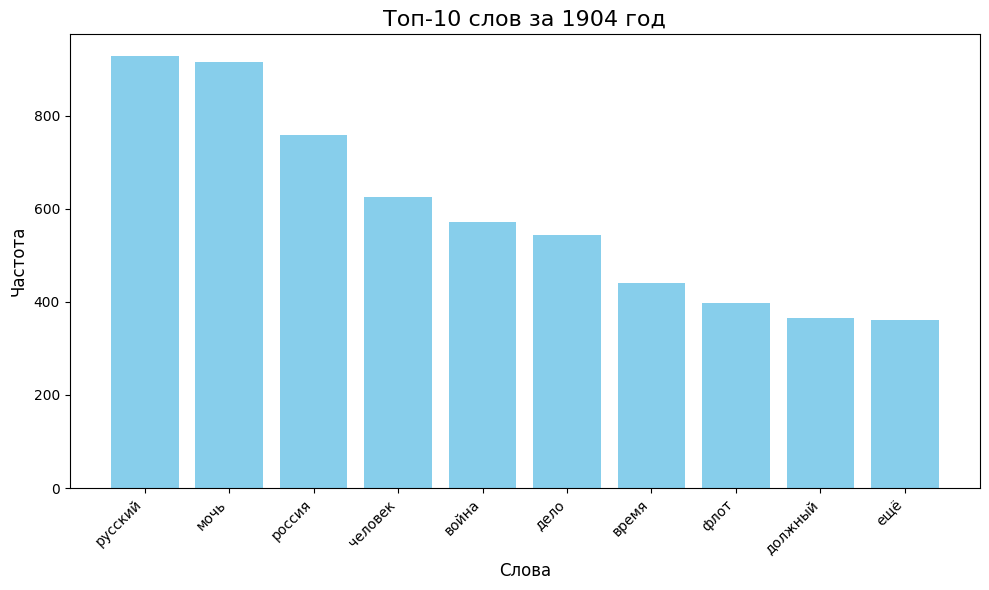

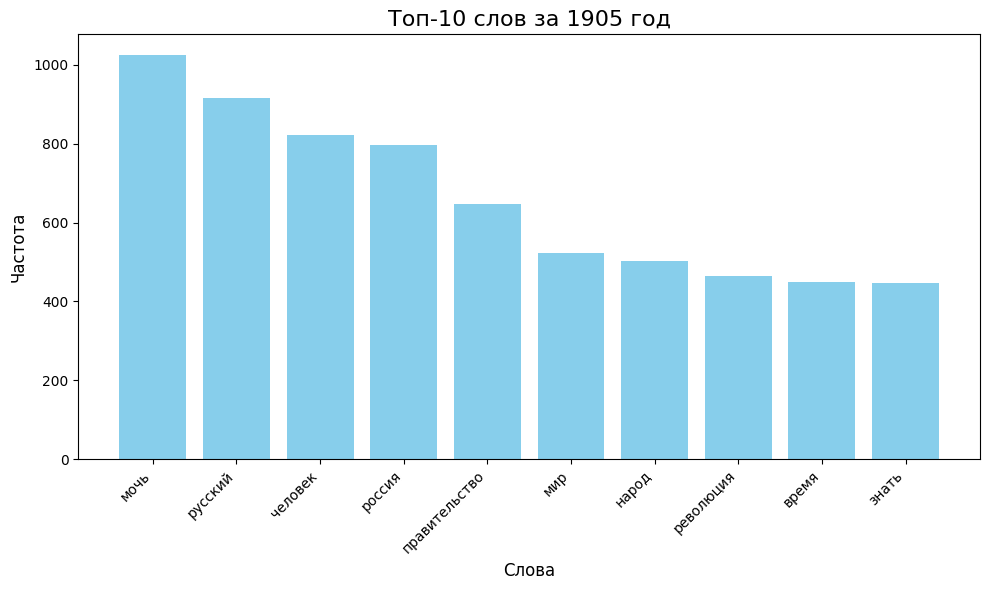

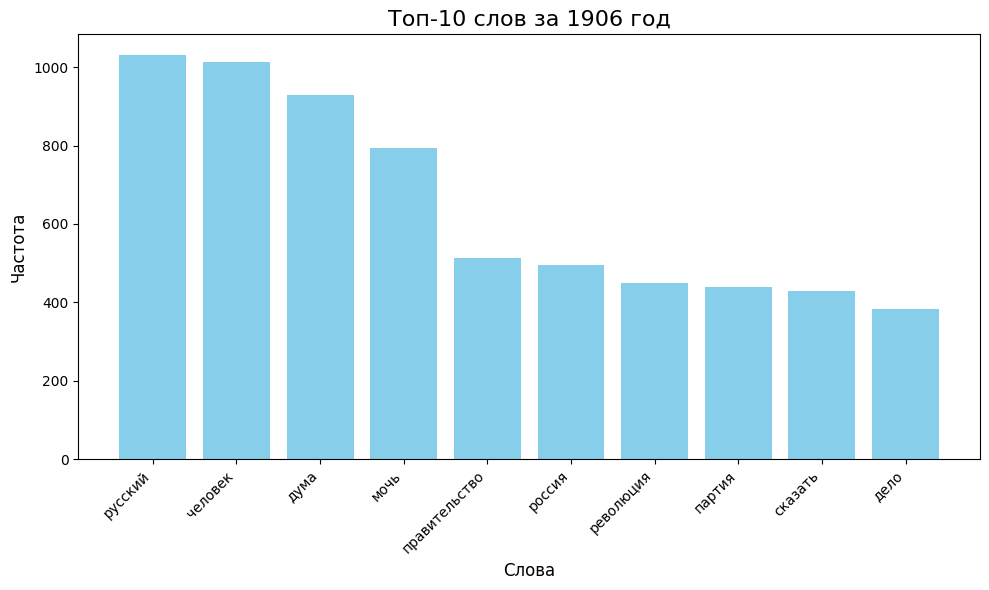

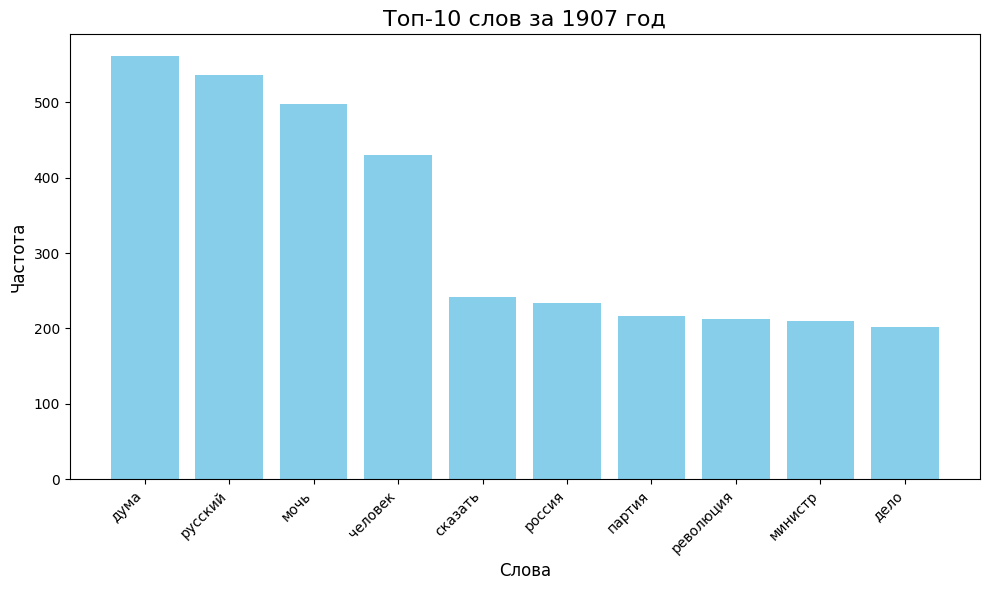

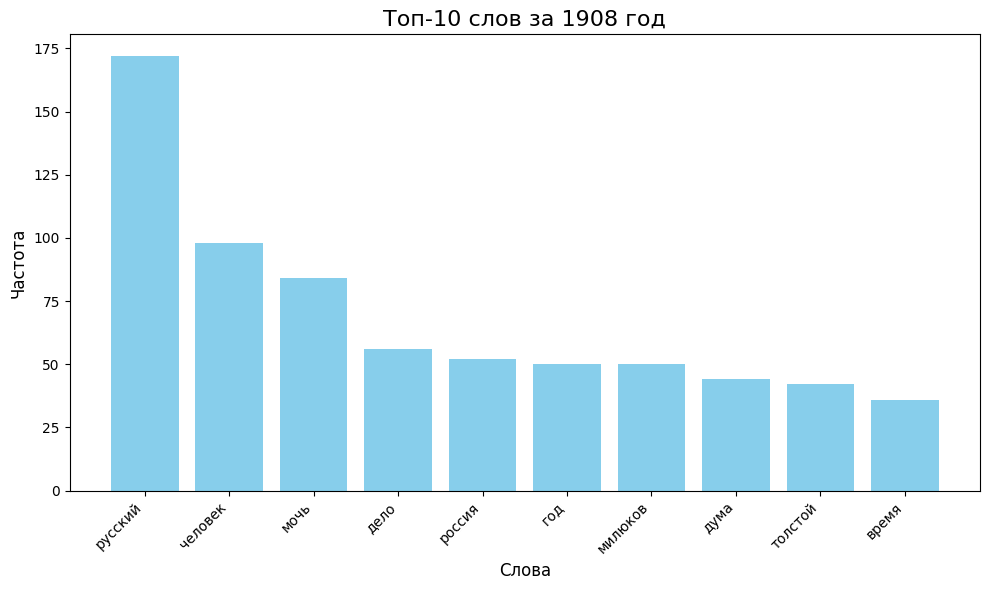

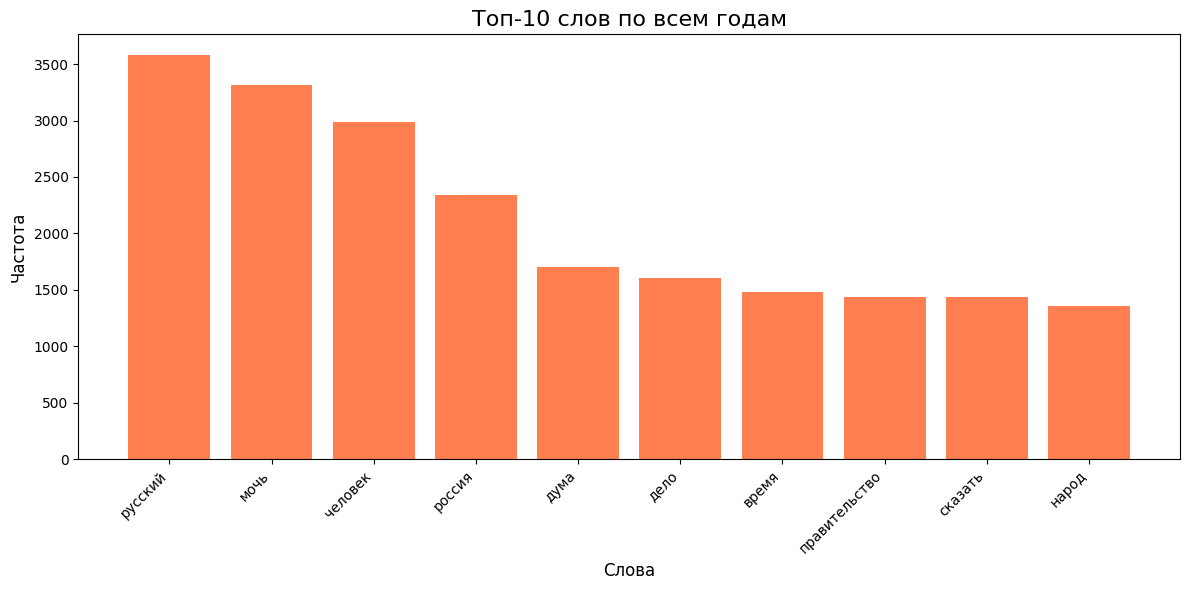

In [22]:
# Частотные слова
# Инициализация морфологического анализатора и стоп-слов
morph = MorphAnalyzer()
nltk_stops = stopwords.words('russian')
custom_stops = {"это", "весь", "всё", "оно", "который", "такой", "свой", "наш", "письма", "дата", "текст", "номер", "выпуск", "говорить"}
stops = set(nltk_stops).union(custom_stops)

# Функция для очистки текста
def preprocess_text_fixed(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление переводов строк, латинских символов и чисел
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[a-zA-Z…]', '', text)
    text = re.sub(r'\d+', '', text)

    # Токенизация
    tokens = word_tokenize(text)

    # Удаление коротких слов, пунктуации и очистка от лишних символов
    tokens = [re.sub(r'\W+', '', token) for token in tokens if len(token) > 2]

    # Лемматизация
    tokens = [morph.parse(token)[0].normal_form for token in tokens]

    # Удаление стоп-слов после лемматизации
    tokens = [token for token in tokens if token not in stops]

    return tokens

# Функция для анализа текста из файлов
def analyze_texts(input_dir):
    results = {}

    # Получаем список текстовых файлов
    files = [file for file in os.listdir(input_dir) if file.endswith(".txt")]

    # Словарь для агрегации данных по всем годам
    aggregated_counter = Counter()

    for file in files:
        year = file.split(".")[0]  # Извлечение года из имени файла
        file_path = os.path.join(input_dir, file)

        # Чтение текста
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        # Предобработка текста
        tokens = preprocess_text_fixed(text)

        # Подсчет частот слов
        word_counter = Counter(tokens)
        most_common_words = word_counter.most_common(10)  # Топ-10 слов

        # Сохранение результатов
        results[year] = most_common_words

        # Агрегация данных
        aggregated_counter.update(word_counter)

    # Вывод данных в терминал
    for year, words in sorted(results.items()):
        print(f"Топ-10 слов за {year} год:")
        for word, freq in words:
            print(f"   {word}: {freq} раз")
        print("-" * 40)

    # Визуализация данных
    visualize_results(results, aggregated_counter)

# Функция для визуализации результатов
def visualize_results(results, aggregated_counter):
    # Диаграммы по каждому году
    for year, words in sorted(results.items()):
        words, freqs = zip(*words)

        # Создание столбчатой диаграммы
        plt.figure(figsize=(10, 6))
        plt.bar(words, freqs, color="skyblue")
        plt.title(f"Топ-10 слов за {year} год", fontsize=16)
        plt.xlabel("Слова", fontsize=12)
        plt.ylabel("Частота", fontsize=12)
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.tight_layout()
        plt.show()

    # Общая диаграмма по всем годам
    common_words = aggregated_counter.most_common(10)
    words, freqs = zip(*common_words)

    plt.figure(figsize=(12, 6))
    plt.bar(words, freqs, color="coral")
    plt.title("Топ-10 слов по всем годам", fontsize=16)
    plt.xlabel("Слова", fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()

# Запуск функции
input_dir = "/content/"  # Укажите папку с текстами за каждый год
analyze_texts(input_dir)



### Извлечение стилометрических признаков

Функция extract_stylometric_features:

* Среднюю длину предложений в тексте (в словах).
* Среднюю длину слов (в символах).
* Топ-10 самых частых слов, биграмм и триграмм.
* Количество редких слов (встречающихся ≤ 2 раза).


In [23]:
# Стилометрические признаки
# Инициализация морфологического анализатора и стоп-слов
morph = MorphAnalyzer()
nltk_stops = stopwords.words('russian')
custom_stops = {"это", "весь", "который", "такой", "свой", "наш", "письмо", "дата", "текст", "номер", "выпуск"}
stops = set(nltk_stops).union(custom_stops)

# Шаблоны для удаления
additional_patterns = [
    r'письмо\s+дата', r'дата\s+номер', r'номер\s+выпуск', r'текст\s+письмо', r'дата\s+(\w+)',
    r'который', r'это', r'такой', r'свой', r'наш'
]

# Функция для очистки текста от заданных шаблонов
def remove_patterns(text, patterns):
    for pattern in patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    return text

# Функция для предобработки текста
def preprocess_text(text):
    text = remove_patterns(text, additional_patterns)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'\W+', '', token) for token in tokens if len(token) > 2]
    tokens = [token for token in tokens if token not in stops]
    tokens = [morph.parse(token)[0].normal_form for token in tokens]
    tokens = [token for token in tokens if token not in stops]
    return tokens

# Функция для извлечения стилометрических признаков
def extract_stylometric_features(text):
    sentences = sent_tokenize(text)
    num_sentences = len(sentences)

    tokens = preprocess_text(text)
    num_tokens = len(tokens)

    avg_sentence_length = num_tokens / num_sentences if num_sentences > 0 else 0
    avg_word_length = sum(len(token) for token in tokens) / num_tokens if num_tokens > 0 else 0

    word_counter = Counter(tokens)
    most_common_words = word_counter.most_common(10)

    rare_words = [word for word, count in word_counter.items() if count <= 2]

    bigrams = list(zip(tokens[:-1], tokens[1:]))
    trigrams = list(zip(tokens[:-2], tokens[1:-1], tokens[2:]))
    bigram_counter = Counter(bigrams)
    trigram_counter = Counter(trigrams)
    most_common_bigrams = bigram_counter.most_common(10)
    most_common_trigrams = trigram_counter.most_common(10)

    complex_sentences = [sent for sent in sentences if re.search(r'\bи\b|\bили\b|\bчто\b|\bкак\b', sent)]
    num_complex_sentences = len(complex_sentences)

    return {
        "avg_sentence_length": avg_sentence_length,
        "avg_word_length": avg_word_length,
        "most_common_words": most_common_words,
        "rare_words_count": len(rare_words),
        "most_common_bigrams": most_common_bigrams,
        "most_common_trigrams": most_common_trigrams,
        "num_complex_sentences": num_complex_sentences
    }

# Функция для сохранения признаков в CSV
def save_features_to_csv(features, file_name, output_dir="features_output"):
    csv_file_path = os.path.join(output_dir, f"{file_name}_features.csv")
    with open(csv_file_path, mode='w', encoding='utf-8', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Добавляем строгую структуру строк: две колонки для каждой строки
        writer.writerow(["Признак", "Значение"])

        # Простые метрики
        writer.writerow(["Средняя длина предложений (слов)", f"{features['avg_sentence_length']:.2f}"])
        writer.writerow(["Средняя длина слов (символов)", f"{features['avg_word_length']:.2f}"])
        writer.writerow(["Количество редких слов", features["rare_words_count"]])
        writer.writerow(["Количество сложных предложений", features["num_complex_sentences"]])

        # Самые частые слова
        writer.writerow(["Самые частые слова (слово: количество)", ""])  # Заголовок раздела
        for word, freq in features["most_common_words"]:
            writer.writerow([word, freq])

        # Самые частые биграммы
        writer.writerow(["Самые частые биграммы (биграмма: количество)", ""])  # Заголовок раздела
        for bigram, freq in features["most_common_bigrams"]:
            writer.writerow([" ".join(bigram), freq])

        # Самые частые триграммы
        writer.writerow(["Самые частые триграммы (триграмма: количество)", ""])  # Заголовок раздела
        for trigram, freq in features["most_common_trigrams"]:
            writer.writerow([" ".join(trigram), freq])

# Функция для вывода результатов в терминал
def display_features(features, file_name):
    print(f"Стилометрические признаки файла {file_name}:")
    print(f"1. Средняя длина предложений: {features['avg_sentence_length']:.2f} слов")
    print(f"2. Средняя длина слов: {features['avg_word_length']:.2f} символов")
    print("3. Самые частые слова:")
    for word, freq in features["most_common_words"]:
        print(f"   {word}: {freq} раз")
    print(f"4. Количество редких слов: {features['rare_words_count']}")
    print("5. Самые частые биграммы:")
    for bigram, freq in features["most_common_bigrams"]:
        print(f"   {' '.join(bigram)}: {freq} раз")
    print("6. Самые частые триграммы:")
    for trigram, freq in features["most_common_trigrams"]:
        print(f"   {' '.join(trigram)}: {freq} раз")
    print(f"7. Количество сложных предложений: {features['num_complex_sentences']}")

# Функция для обработки файла
def process_file_for_features(file_path, output_dir):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[a-zA-Z…]', '', text)
    text = re.sub(r'\d+', '', text)

    features = extract_stylometric_features(text)
    return features

# Основная функция
def main(input_dir=".", output_dir="features_output"):
    os.makedirs(output_dir, exist_ok=True)
    files = [file for file in os.listdir(input_dir) if file.endswith(".txt")]

    for file in files:
        print(f"Обработка файла {file}...")
        features = process_file_for_features(os.path.join(input_dir, file), output_dir)
        display_features(features, file.split(".")[0])  # Вывод данных в терминал
        save_features_to_csv(features, file.split(".")[0], output_dir)  # Сохранение в CSV
    print("Обработка завершена!")

if __name__ == "__main__":
    main(input_dir=".", output_dir="features_output")

Обработка файла 1905.txt...
Стилометрические признаки файла 1905:
1. Средняя длина предложений: 8.88 слов
2. Средняя длина слов: 7.55 символов
3. Самые частые слова:
   русский: 916 раз
   говорить: 848 раз
   человек: 822 раз
   россия: 796 раз
   правительство: 648 раз
   мир: 524 раз
   народ: 502 раз
   оно: 486 раз
   революция: 464 раз
   время: 450 раз
4. Количество редких слов: 4150
5. Самые частые биграммы:
   земский собор: 244 раз
   граф витта: 182 раз
   русский человек: 100 раз
   государственный дума: 100 раз
   русский народ: 74 раз
   учредительный собрание: 74 раз
   друг друг: 68 раз
   русский земля: 58 раз
   совет рабочий: 56 раз
   дальний восток: 54 раз
6. Самые частые триграммы:
   совет рабочий депутат: 54 раз
   правительство граф витта: 48 раз
   министр народный просвещение: 30 раз
   высокий учебный заведение: 20 раз
   говорить земский собор: 14 раз
   созыв земский собор: 14 раз
   созыв государственный дума: 12 раз
   иметь право сказать: 10 раз
   врем

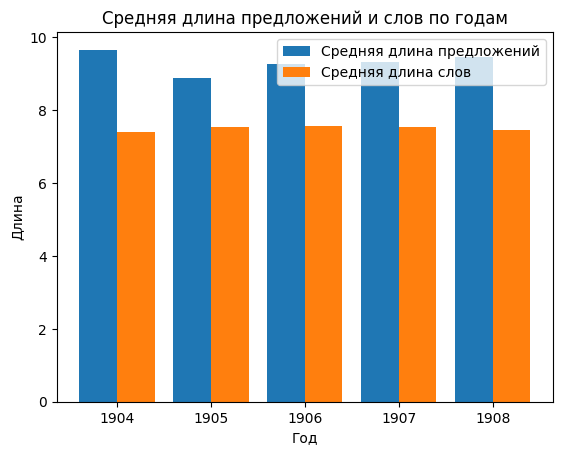

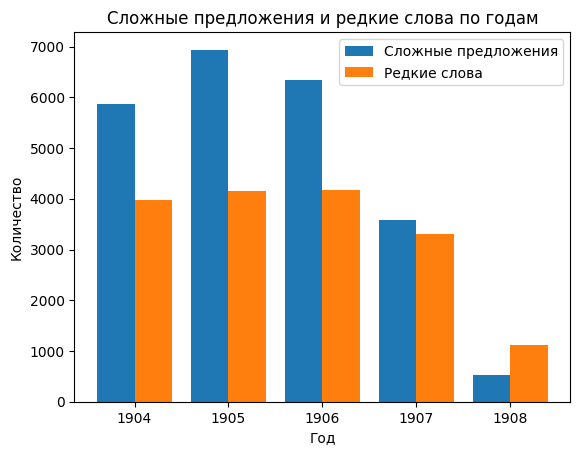

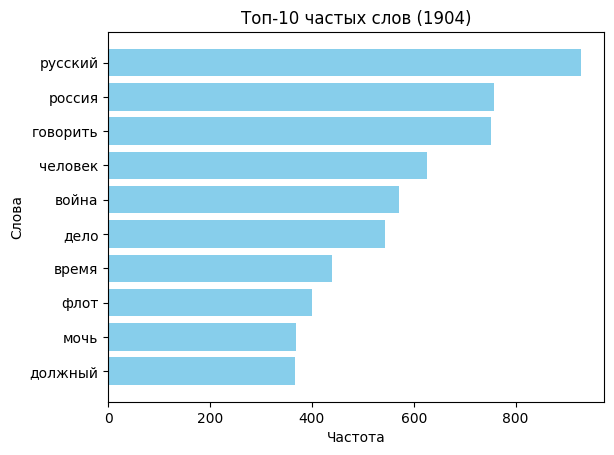

Нет данных для биграмм (1904)


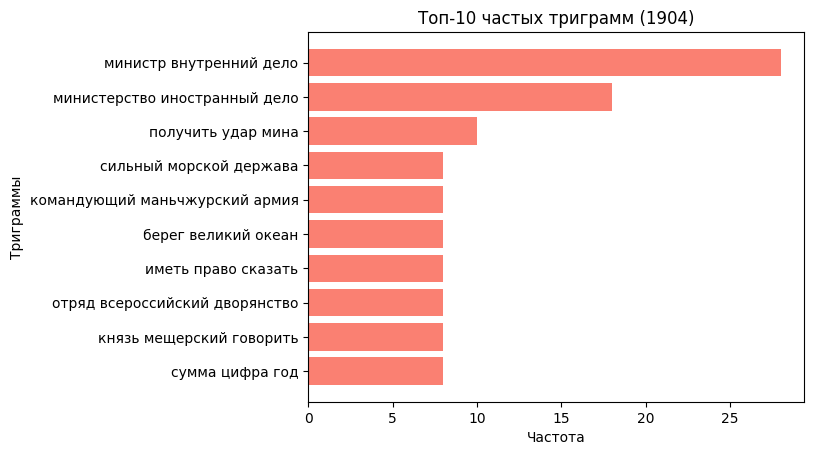

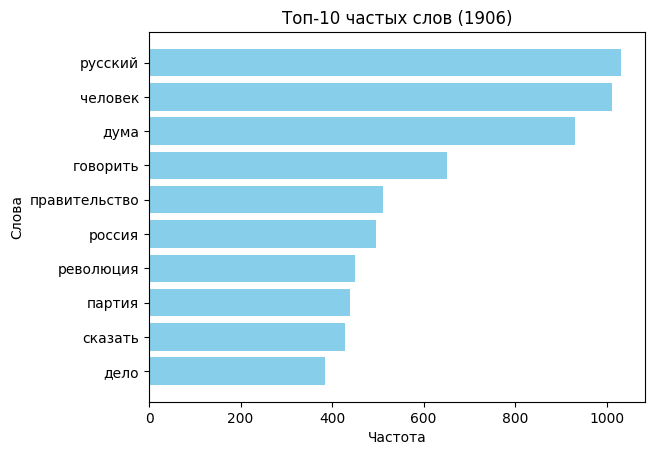

Нет данных для биграмм (1906)


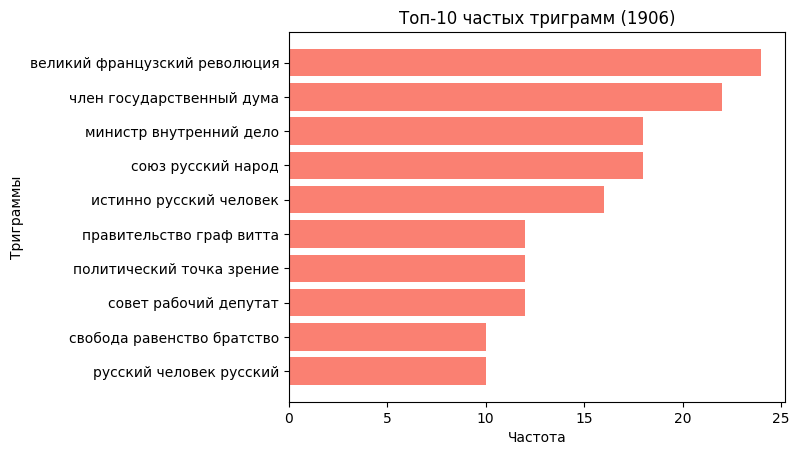

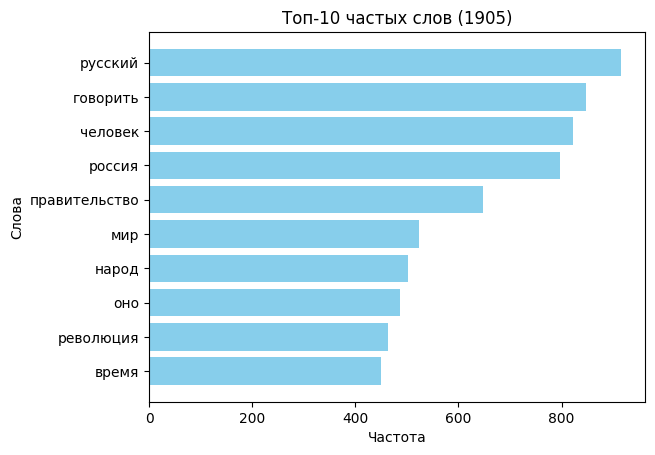

Нет данных для биграмм (1905)


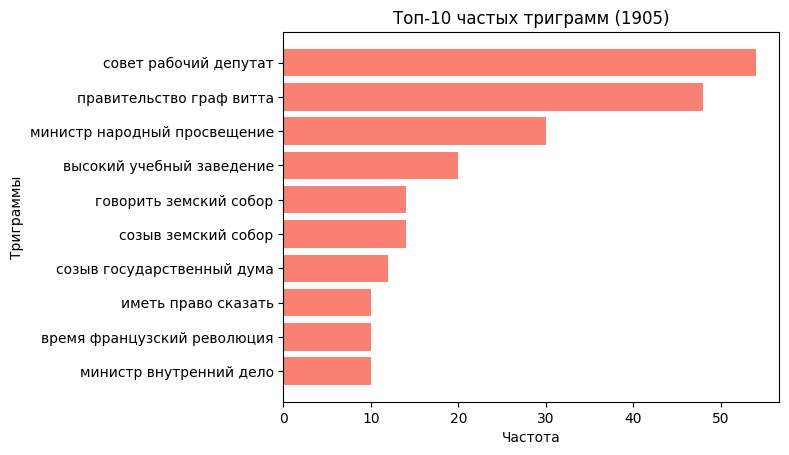

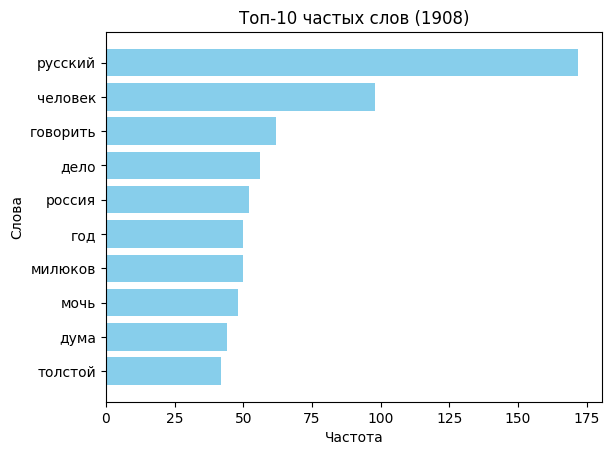

Нет данных для биграмм (1908)


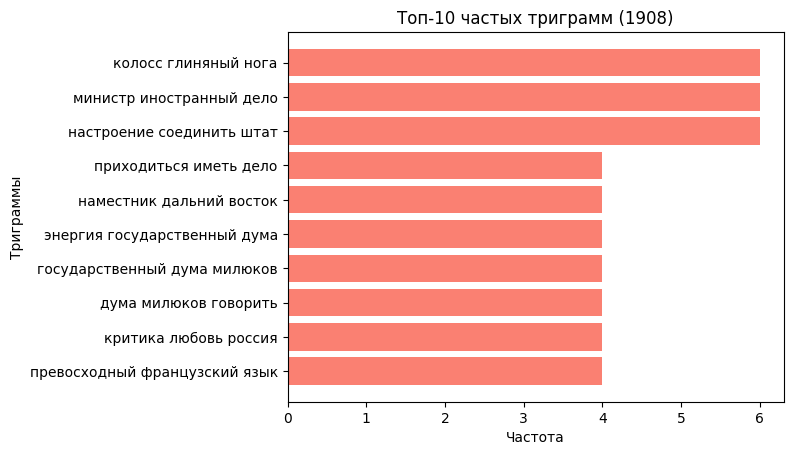

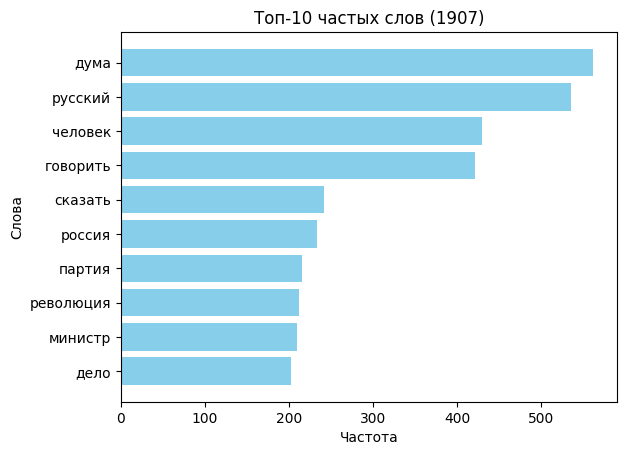

Нет данных для биграмм (1907)


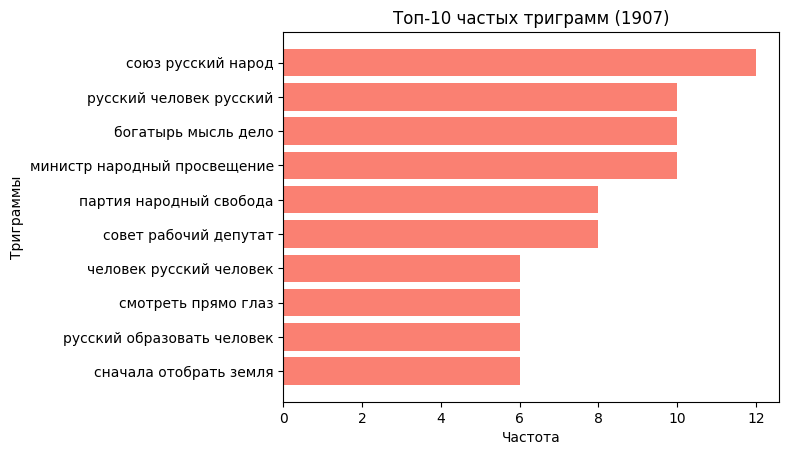

In [24]:
# Визуализация результатов
# Функция для чтения данных из CSV
def read_csv_metrics(input_dir):
    data = {}
    for file in os.listdir(input_dir):
        if file.endswith("_features.csv"):
            year = file.split("_")[0]
            data[year] = {
                "avg_sentence_length": 0,
                "avg_word_length": 0,
                "num_complex_sentences": 0,
                "rare_words_count": 0,
                "most_common_words": [],
                "most_common_bigrams": [],
                "most_common_trigrams": [],
            }
            with open(os.path.join(input_dir, file), encoding="utf-8") as f:
                reader = csv.reader(f)
                next(reader)  # Пропуск заголовка
                for row in reader:
                    if row[0] == "Средняя длина предложений (слов)":
                        data[year]["avg_sentence_length"] = float(row[1])
                    elif row[0] == "Средняя длина слов (символов)":
                        data[year]["avg_word_length"] = float(row[1])
                    elif row[0] == "Количество редких слов":
                        data[year]["rare_words_count"] = int(row[1])
                    elif row[0] == "Количество сложных предложений":
                        data[year]["num_complex_sentences"] = int(row[1])
                    elif row[0] == "Самые частые слова (слово: количество)":
                        for word_row in reader:
                            if not word_row[0] or not word_row[1]:
                                break
                            data[year]["most_common_words"].append((word_row[0], int(word_row[1])))
                    elif row[0] == "Самые частые биграммы (биграмма: количество)":
                        for bigram_row in reader:
                            if not bigram_row[0] or not bigram_row[1]:
                                break
                            bigram = tuple(bigram_row[0].split())
                            data[year]["most_common_bigrams"].append((bigram, int(bigram_row[1])))
                    elif row[0] == "Самые частые триграммы (триграмма: количество)":
                        for trigram_row in reader:
                            if not trigram_row[0] or not trigram_row[1]:
                                break
                            trigram = tuple(trigram_row[0].split())
                            data[year]["most_common_trigrams"].append((trigram, int(trigram_row[1])))
    return data

# Функции визуализации
def visualize_avg_lengths(data):
    years = sorted(data.keys())
    avg_sentence_lengths = [data[year]["avg_sentence_length"] for year in years]
    avg_word_lengths = [data[year]["avg_word_length"] for year in years]

    x = np.arange(len(years))
    width = 0.4

    plt.bar(x - width / 2, avg_sentence_lengths, width, label="Средняя длина предложений")
    plt.bar(x + width / 2, avg_word_lengths, width, label="Средняя длина слов")

    plt.xlabel("Год")
    plt.ylabel("Длина")
    plt.title("Средняя длина предложений и слов по годам")
    plt.xticks(x, years)
    plt.legend()
    plt.show()

def visualize_complex_and_rare(data):
    years = sorted(data.keys())
    complex_sentences = [data[year]["num_complex_sentences"] for year in years]
    rare_words = [data[year]["rare_words_count"] for year in years]

    x = np.arange(len(years))
    width = 0.4

    plt.bar(x - width / 2, complex_sentences, width, label="Сложные предложения")
    plt.bar(x + width / 2, rare_words, width, label="Редкие слова")

    plt.xlabel("Год")
    plt.ylabel("Количество")
    plt.title("Сложные предложения и редкие слова по годам")
    plt.xticks(x, years)
    plt.legend()
    plt.show()

def visualize_frequent_words(data, year):
    if not data[year]["most_common_words"]:  # Проверка наличия данных
        print(f"Нет данных для частых слов ({year})")
        return

    words, counts = zip(*data[year]["most_common_words"])

    plt.barh(words, counts, color="skyblue")
    plt.xlabel("Частота")
    plt.ylabel("Слова")
    plt.title(f"Топ-10 частых слов ({year})")
    plt.gca().invert_yaxis()
    plt.show()

def visualize_frequent_bigrams(data, year):
    if not data[year]["most_common_bigrams"]:  # Проверка наличия данных
        print(f"Нет данных для биграмм ({year})")
        return

    bigrams, counts = zip(*data[year]["most_common_bigrams"])

    plt.barh([" ".join(bigram) for bigram in bigrams], counts, color="lightgreen")
    plt.xlabel("Частота")
    plt.ylabel("Биграммы")
    plt.title(f"Топ-10 частых биграмм ({year})")
    plt.gca().invert_yaxis()
    plt.show()

def visualize_frequent_trigrams(data, year):
    if not data[year]["most_common_trigrams"]:  # Проверка наличия данных
        print(f"Нет данных для триграмм ({year})")
        return

    trigrams, counts = zip(*data[year]["most_common_trigrams"])

    plt.barh([" ".join(trigram) for trigram in trigrams], counts, color="salmon")
    plt.xlabel("Частота")
    plt.ylabel("Триграммы")
    plt.title(f"Топ-10 частых триграмм ({year})")
    plt.gca().invert_yaxis()
    plt.show()

# Основная функция
if __name__ == "__main__":
    input_dir = "features_output"  # Папка с CSV-файлами
    data = read_csv_metrics(input_dir)

    # Визуализация по всем годам
    visualize_avg_lengths(data)
    visualize_complex_and_rare(data)

    # Визуализация для каждого года
    for year in data.keys():
        visualize_frequent_words(data, year)
        visualize_frequent_bigrams(data, year)
        visualize_frequent_trigrams(data, year)

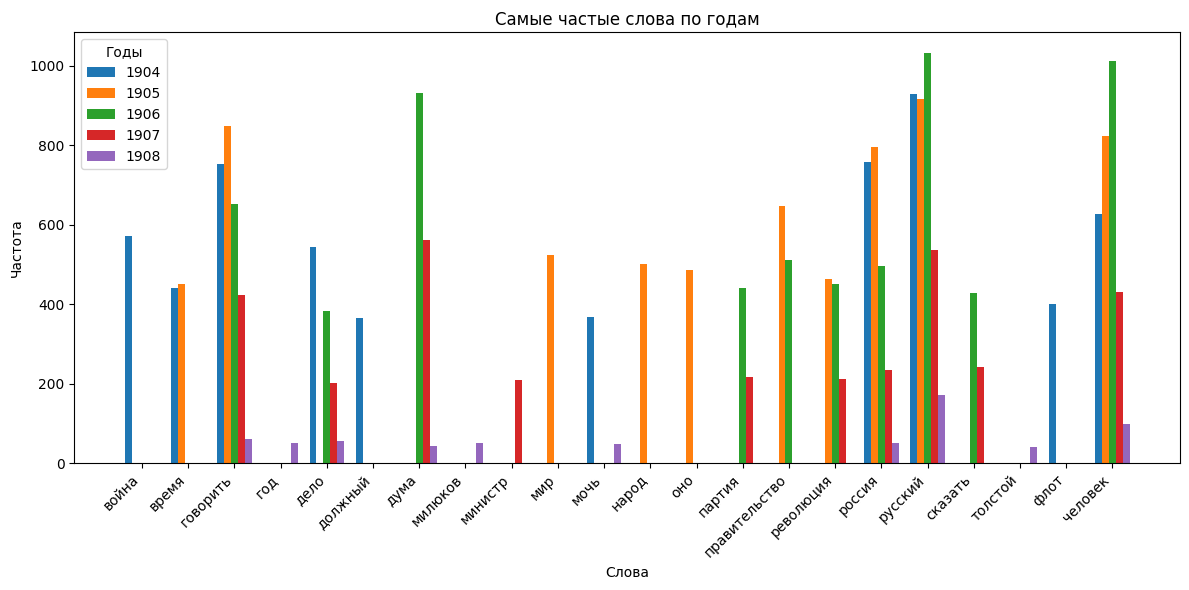

In [25]:
# Визуализация частотных слов по годам
def visualize_common_words_across_years(data):
    # Собираем уникальные слова из всех годов
    all_words = set()
    for year in data.keys():
        all_words.update([word for word, _ in data[year]["most_common_words"]])

    # Подготавливаем данные для группированной диаграммы
    all_words = sorted(all_words)  # Сортируем слова для консистентности
    years = sorted(data.keys())
    word_frequencies = {year: [0] * len(all_words) for year in years}

    for year in years:
        for word, freq in data[year]["most_common_words"]:
            if word in all_words:
                word_frequencies[year][all_words.index(word)] = freq

    # Построение группированного столбчатого графика
    x = np.arange(len(all_words))  # Позиции для слов
    width = 0.15  # Ширина каждого столбца

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, year in enumerate(years):
        ax.bar(x + i * width, word_frequencies[year], width, label=f"{year}")

    # Настройка осей и подписей
    ax.set_xlabel("Слова")
    ax.set_ylabel("Частота")
    ax.set_title("Самые частые слова по годам")
    ax.set_xticks(x + (len(years) - 1) * width / 2)
    ax.set_xticklabels(all_words, rotation=45, ha="right")
    ax.legend(title="Годы")

    plt.tight_layout()
    plt.show()

# Пример использования:
if __name__ == "__main__":
    input_dir = "features_output"  # Папка с CSV-файлами
    data = read_csv_metrics(input_dir)

    # Визуализация самых частых слов по всем годам
    #visualize_common_words_across_years(data)
    visualize_common_words_across_years(data)

# Сбор данных для контрольного корпуса

Розанов В. В. Собрание сочинений. Признаки времени (Статьи и очерки 1912 г.) М.: Республика, Алгоритм, 2006.

Письма С.А. Суворина к В.В. Розанову

In [27]:
# Контрольный текст письма С.А. Суворина В.В. Розанову

import re

# Путь к файлу .fb2
fb2_file_path = "/content/suworin_a_s-text_1912_pisma_k_rozanovu.fb2"

# Функция для извлечения текста между тегами
def extract_text_between_tags(file_path, start_tag, end_tag):
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()  # Чтение всего файла

        # Разбиение текста на части
        extracted_text = []
        parts = content.split(start_tag)[1:]  # Убираем все до первого <p></p>
        for part in parts:
            # Берем текст до <p></p>
            text_part = part.split(end_tag)[0]
            extracted_text.append(text_part.strip())

        # Объединение всех частей
        result = "\n".join(extracted_text)

        # Очистка текста
        result = clean_text_1(result)

        # Вывод первых 5 строк результата
        print("\nПервые 5 строк извлеченного текста:")
        print("\n".join(result.splitlines()[:5]))

        # Вывод количества символов
        print(f"\nКоличество символов в полученном тексте: {len(result)}")

        return result

    except FileNotFoundError:
        print(f"Файл не найден: {file_path}")
    except Exception as e:
        print(f"Ошибка при обработке файла: {e}")

# Функция для очистки текста
def clean_text_1(text):
    # Удаление латинских символов
    text = re.sub(r'[a-zA-Z]', ' ', text)
    # Удаление служебных символов и тегов
    text = re.sub(r'<[^>]+>', ' ', text)
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Теги для поиска
start_tag = "<p> <emphasis>17 августа 93 г.</emphasis></p>"
end_tag = "<p><emphasis>4 мая 912</emphasis></p>"

# Запуск функции
extracted_text = extract_text_between_tags(fb2_file_path, start_tag, end_tag)

# Если нужно сохранить результат в новый файл:
output_path = "/content/extracted_text_1.txt"
with open(output_path, "w", encoding="utf-8") as output_file:
    output_file.write(extracted_text)

print(f"\nИзвлеченный текст сохранен в: {output_path}")


Первые 5 строк извлеченного текста:
Милостивый Государь Василий Васильевич, Я прочитал Вашу статью "Свобода и вера" {Было нечто чудовищное предложить подобную статью газете, -- и показывает все мое "неофитство" тех лет... Статья была помещена в "Русск. Вестнике" и вызвала ответ Влад. Соловьева -- "Порфирий Головлев о свободе и вере". Статью находил тяжелой для чтения Н. Н. Страхов и -- односторонней по содержанию; скорее слишком фанатичной и непрактичной, нецелесообразной. Скоро в полемику вступил и Л. А. Тихомиров, а также вторично отвечал Вл. Соловьев. -- В. Р. }. Тема очень интересная. Но, во-- первых, она не газетная, во-вторых, она изложена не для газеты. О согласии или несогласии с Вами редакции, конечно, не может быть речи, ибо у Вас есть имя. Согласитесь, что читать такую статью на пространстве трех недель, а мы иначе не можем ее печатать, как по одному фельетону в неделю, -- почти немыслимо. Всякая связь теряется, и интерес остается разве только для немногих. Вы указываете на

In [28]:
# Стилометрические признаки файла extracted_text_1
# Загрузка необходимых данных для NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Инициализация морфологического анализатора и стоп-слов
morph = MorphAnalyzer()
nltk_stops = stopwords.words('russian')
custom_stops = {"это", "весь", "который", "такой", "свой", "наш", "письмо", "дата", "текст", "номер", "выпуск"}
stops = set(nltk_stops).union(custom_stops)

# Функция для очистки текста по шаблону
def clean_text(text):
    # Удаление XML/HTML тегов
    text = re.sub(r'<[^>]+>', ' ', text)
    # Удаление латинских символов и многоточий
    text = re.sub(r'[a-zA-Z…]', '', text)
    # Удаление чисел
    text = re.sub(r'\d+', '', text)
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Функция для предобработки текста
def preprocess_text3(text):
    # Очистка текста
    text = clean_text(text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Токенизация
    tokens = word_tokenize(text)
    # Удаление коротких слов, стоп-слов и лемматизация
    tokens = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if len(token) > 2 and token not in stops
    ]
    return tokens

# Функция для извлечения стилометрических признаков
def extract_stylometric_features(text):
    # Разбиение текста на предложения
    sentences = sent_tokenize(text)
    num_sentences = len(sentences)

    # Предобработка текста и токенизация
    tokens = preprocess_text(text)
    num_tokens = len(tokens)

    # Средняя длина предложений
    avg_sentence_length = num_tokens / num_sentences if num_sentences > 0 else 0
    # Средняя длина слов
    avg_word_length = sum(len(token) for token in tokens) / num_tokens if num_tokens > 0 else 0

    # Частотный анализ
    word_counter = Counter(tokens)
    most_common_words = word_counter.most_common(10)
    rare_words_count = sum(1 for count in word_counter.values() if count <= 2)

    # N-граммы
    bigrams = list(zip(tokens[:-1], tokens[1:]))
    trigrams = list(zip(tokens[:-2], tokens[1:-1], tokens[2:]))
    bigram_counter = Counter(bigrams)
    trigram_counter = Counter(trigrams)
    most_common_bigrams = bigram_counter.most_common(10)
    most_common_trigrams = trigram_counter.most_common(10)

    # Количество сложных предложений
    complex_sentences = [sent for sent in sentences if re.search(r'\bи\b|\bили\b|\bчто\b|\bкак\b', sent)]
    num_complex_sentences = len(complex_sentences)

    return {
        "avg_sentence_length": avg_sentence_length,
        "avg_word_length": avg_word_length,
        "most_common_words": most_common_words,
        "rare_words_count": rare_words_count,
        "most_common_bigrams": most_common_bigrams,
        "most_common_trigrams": most_common_trigrams,
        "num_complex_sentences": num_complex_sentences,
    }

# Функция для сохранения признаков в CSV
def save_features_to_csv(features, file_name, output_dir="features_output"):
    os.makedirs(output_dir, exist_ok=True)
    csv_file_path = os.path.join(output_dir, f"{file_name}_features.csv")
    with open(csv_file_path, mode='w', encoding='utf-8', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Признак", "Значение"])
        writer.writerow(["Средняя длина предложений (слов)", f"{features['avg_sentence_length']:.2f}"])
        writer.writerow(["Средняя длина слов (символов)", f"{features['avg_word_length']:.2f}"])
        writer.writerow(["Количество редких слов", features["rare_words_count"]])
        writer.writerow(["Количество сложных предложений", features["num_complex_sentences"]])

        # Запись частых слов
        writer.writerow(["Самые частые слова", "Частота"])
        for word, freq in features["most_common_words"]:
            writer.writerow([word, freq])

        # Запись биграмм
        writer.writerow(["Самые частые биграммы", "Частота"])
        for bigram, freq in features["most_common_bigrams"]:
            writer.writerow([" ".join(bigram), freq])

        # Запись триграмм
        writer.writerow(["Самые частые триграммы", "Частота"])
        for trigram, freq in features["most_common_trigrams"]:
            writer.writerow([" ".join(trigram), freq])

# Функция для вывода результатов в терминал
def display_features(features, file_name):
    print(f"Стилометрические признаки файла {file_name}:")
    print(f"1. Средняя длина предложений: {features['avg_sentence_length']:.2f} слов")
    print(f"2. Средняя длина слов: {features['avg_word_length']:.2f} символов")
    print("3. Самые частые слова:")
    for word, freq in features["most_common_words"]:
        print(f"   {word}: {freq} раз")
    print(f"4. Количество редких слов: {features['rare_words_count']}")
    print("5. Самые частые биграммы:")
    for bigram, freq in features["most_common_bigrams"]:
        print(f"   {' '.join(bigram)}: {freq} раз")
    print("6. Самые частые триграммы:")
    for trigram, freq in features["most_common_trigrams"]:
        print(f"   {' '.join(trigram)}: {freq} раз")
    print(f"7. Количество сложных предложений: {features['num_complex_sentences']}")

# Основная функция
def main3(input_file, output_dir="features_output"):
    with open(input_file, 'r', encoding='utf-8') as file:
        text = file.read()

    # Очистка текста
    text = clean_text(text)

    # Извлечение признаков
    features = extract_stylometric_features(text)

    # Вывод результатов
    display_features(features, os.path.basename(input_file).split(".")[0])

    # Сохранение результатов в CSV
    save_features_to_csv(features, os.path.basename(input_file).split(".")[0], output_dir)

    print("Обработка завершена")

if __name__ == "__main__":
    input_file = "/content/extracted_text_1.txt"
    main3(input_file=input_file) # Call main3 instead of main

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Стилометрические признаки файла extracted_text_1:
1. Средняя длина предложений: 5.99 слов
2. Средняя длина слов: 7.20 символов
3. Самые частые слова:
   ваш: 135 раз
   говорить: 83 раз
   статья: 77 раз
   суворина: 72 раз
   очень: 63 раз
   человек: 58 раз
   василий: 57 раз
   василиевич: 55 раз
   сказать: 54 раз
   время: 53 раз
4. Количество редких слов: 2482
5. Самые частые биграммы:
   василий василиевич: 55 раз
   ваш суворина: 53 раз
   новый время: 21 раз
   ваш статья: 13 раз
   ваш фельетон: 10 раз
   прочесть ваш: 8 раз
   дорога василий: 8 раз
   многоуважаемый василий: 7 раз
   суворина янв: 7 раз
   суворина дек: 6 раз
6. Самые частые триграммы:
   дорога василий василиевич: 8 раз
   многоуважаемый василий василиевич: 7 раз
   ваш суворина янв: 7 раз
   ваш суворина дек: 6 раз
   василий василиевич прочесть: 5 раз
   ваш суворина июль: 5 раз
   ваш суворина ноябнуть: 5 раз
   прочесть ваш фельетон: 4 раз
   здравствуйте василий василиевич: 4 раз
   василий василиевич 

# **Анализатор Burrows’ Delta**

Код выполняет сравнительный анализ текстов на основе стилистических особенностей:

* Тексты за 1905–1908 годы сравниваются с текстами за 1904 год.
* Анализ проводится по методу Burrows’ Delta, который выявляет различия в стилях на основе частотного использования слов.
* Результаты помогают оценить, насколько стилистика тестовых текстов близка к стилистике тренировочного текста.


*Чем меньше значение Burrows’ Delta для года, тем больше вероятность, что его стиль близок к стилю текстов за 1904 год*.

Анализатор Burrows’ Delta взят из проекта Fast Stylometry Python Library компании **Fast Data Science**: https://fastdatascience.com/natural-language-processing/fast-stylometry-python-library/

Часть кода на python взята из репозитария проекта с GitHub: https://colab.research.google.com/github/fastdatascience/faststylometry/blob/main/Burrows%20Delta%20Walkthrough.ipynb#scrollTo=-4a6RYWhpt2w


In [2]:
!pip install faststylometry # установка библиотеки Fast Stylometry model for Burrows' Delta

In [7]:
# Fast Stylometry model for Burrows' Delta
!pip install pymorphy3
import nltk
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer

# Загрузка необходимых ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')
# Настройка морфологического анализатора и стоп-слов
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

# Предобработка текста
def preprocess_text(text):
    """
    Преобразование текста: приведение к нижнему регистру, лемматизация, удаление стоп-слов и пунктуации.
    """
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [morph.parse(word)[0].normal_form for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Создание частотного словаря
def build_frequency_dict(texts):
    """
    Создание частотного словаря на основе текста.
    """
    freq_dict = Counter()
    for text in texts:
        tokens = preprocess_text(text)
        freq_dict.update(tokens)
    return freq_dict

# Вычисление Z-оценок
def calculate_z_scores(freq_dict, vocab):
    """
    Вычисление Z-оценок для слов из словаря.
    """
    total_count = sum(freq_dict.values())
    z_scores = {}
    for word in vocab:
        freq = freq_dict.get(word, 0) / total_count
        mean = np.mean([freq_dict.get(w, 0) for w in vocab]) / total_count
        std = np.std([freq_dict.get(w, 0) for w in vocab]) / total_count
        z_scores[word] = (freq - mean) / (std if std > 0 else 1)
    return z_scores

# Burrows' Delta
def burrows_delta(z1, z2, vocab):
    """
    Вычисление метрики Burrows' Delta между двумя наборами Z-оценок.
    """
    delta = np.mean([abs(z1[word] - z2[word]) for word in vocab])
    return delta

# Основной процесс
def main(train_file, test_files):
    """
    Основная функция для анализа текстов.
    """
    # Чтение тренировочного текста
    with open(train_file, 'r', encoding='utf-8') as file:
        train_text = file.read()

    # Чтение тестовых текстов
    test_texts = {}
    for test_file in test_files:
        with open(test_file, 'r', encoding='utf-8') as file:
            test_texts[test_file] = file.read()

    # Частотный словарь для тренировочного текста
    train_freq = build_frequency_dict([train_text])

    # Частотные словари для тестовых текстов
    test_freqs = {file: build_frequency_dict([text]) for file, text in test_texts.items()}

    # Общий словарь (в топ-500 слов)
    vocab = [word for word, _ in train_freq.most_common(500)]

    # Z-оценки для тренировочного текста
    train_z = calculate_z_scores(train_freq, vocab)

    # Расчет Burrows' Delta для каждого тестового текста
    for file, freq in test_freqs.items():
        test_z = calculate_z_scores(freq, vocab)
        delta = burrows_delta(train_z, test_z, vocab)
        print(f"Burrows' Delta для {file}: {delta:.4f}")

# Запуск
train_file = "/content/1904.txt"
test_files = [
    "/content/1905.txt",
    "/content/1906.txt",
    "/content/1907.txt",
    "/content/1908.txt",
    "/content/extracted_text_1.txt"
]
main(train_file, test_files)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Burrows' Delta для /content/1905.txt: 0.2288
Burrows' Delta для /content/1906.txt: 0.2729
Burrows' Delta для /content/1907.txt: 0.2651
Burrows' Delta для /content/1908.txt: 0.2921
Burrows' Delta для /content/extracted_text_1.txt: 0.4024




# Реализация метрики Burrows’ Delta


1.	Предобработка текста:

	* Приведение к нижнему регистру.
	* Токенизация текста с использованием библиотеки nltk.
	* Лемматизация слов с помощью библиотеки pymorphy3.
	* Удаление пунктуации и стоп-слов.
2.	Вычисление Z-оценок:
 * Для каждого слова вычисляется его частота относительно общего числа слов.
	* Используется словарь из топ-500 слов (по частоте) из тренировочного текста.
	* Z-оценки рассчитываются как стандартное отклонение частот каждого слова.
3.	Burrows’ Delta:
	* Вычисляется как среднее арифметическое разностей Z-оценок между словами двух текстов.
4.	Тренировочный и тестовые тексты:
	* Тренировочный текст: /content/1904.txt.
	* Тестовые тексты: /content/1905.txt, /content/1906.txt, /content/1907.txt, /content/1908.txt, /content/extracted_text_1.txt.
5.	Результаты:
	* Для каждого тестового текста вычисляется метрика Burrows’ Delta относительно тренировочного текста.

## Интерпретация результатов

Burrows’ Delta для /content/1905.txt: 0.2288:

* Текст 1905 года наиболее стилистически схож с текстами 1904 года. Низкое значение метрики указывает на то, что частоты ключевых слов и их стилистика близки к тренировочному корпусу.

Burrows’ Delta для /content/1906.txt: 0.2729:

* Текст 1906 года демонстрирует небольшое увеличение стилистического расхождения по сравнению с 1904 годом, но все еще находится в пределах близости.

Burrows’ Delta для /content/1907.txt: 0.2651:

* Тексты за 1907 год также имеют близкую стилистику к текстам 1904 года, хотя немного отличается.

Burrows’ Delta для /content/1908.txt: 0.2921:

* Тексты за 1908 года демонстрируют большее стилистическое отличие по сравнению с предыдущими годами. Это может свидетельствовать о возможных изменениях в стиле письма или тематике.

Burrows’ Delta для /content/extracted_text_1.txt: 0.4024:

* Текст “extracted_text_1” показывает самое большое стилистическое расхождение. Это подтверждает гипотезу о том, что этот текст принадлежит тому же автору, но не является частью корпуса 1904-1908 годов.

# Выводы

1.	Стилистическая близость текстов:
* Тексты за 1905, 1906 и 1907 годы имеют минимальные различия с текстами 1904 года. Это свидетельствует о сохранении авторского стиля и тематики.

* Текст за 1908 год немного отличается, возможно, из-за изменений в стиле автора или особенностей содержания.

2. Текст “extracted_text_1”:
* Наиболее вероятно, что он принадлежит тому же автору, но его лексика и стилистика отличаются. Это может быть вызвано разной аудиторией, тематикой или временным интервалом написания.


In [8]:
import matplotlib.pyplot as plt

In [9]:
# Визуализация
def visualize_delta_scores(delta_scores):
    """
    Визуализирует значения Burrows' Delta для текстов.

    :param delta_scores: Словарь, где ключи — года, значения — Burrows' Delta.
    """
    years = list(delta_scores.keys())
    scores = list(delta_scores.values())

    # Построение линейного графика
    plt.figure(figsize=(10, 6))
    plt.plot(years, scores, marker='o', linestyle='-', color='blue')
    plt.xlabel("Годы")
    plt.ylabel("Burrows' Delta")
    plt.title("Сравнение стилей текстов по Burrows' Delta")
    plt.grid(True)
    plt.xticks(years)
    plt.tight_layout()
    plt.show()

def visualize_comparison(delta_scores, threshold=0.5):
    """
    Визуализирует сравнение Burrows' Delta с заданным порогом.

    :param delta_scores: Словарь, где ключи — года, значения — Burrows' Delta.
    :param threshold: Пороговое значение для визуализации.
    """
    years = list(delta_scores.keys())
    scores = list(delta_scores.values())

    # Построение столбчатого графика
    plt.figure(figsize=(10, 6))
    bars = plt.bar(years, scores, color=['green' if score < threshold else 'red' for score in scores])
    plt.axhline(y=threshold, color='black', linestyle='--', label=f"Порог: {threshold}")
    plt.xlabel("Годы")
    plt.ylabel("Burrows' Delta")
    plt.title("Сравнение текстов с пороговым значением Burrows' Delta")
    plt.legend()
    plt.tight_layout()

    # Добавление значений на вершинах столбцов
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

    plt.show()

def visualize_all_data(delta_scores):
    """
    Визуализирует Burrows' Delta как в виде линейного, так и в виде столбчатого графика.

    :param delta_scores: Словарь, где ключи — года, значения — Burrows' Delta.
    """
    visualize_delta_scores(delta_scores)
    visualize_comparison(delta_scores)

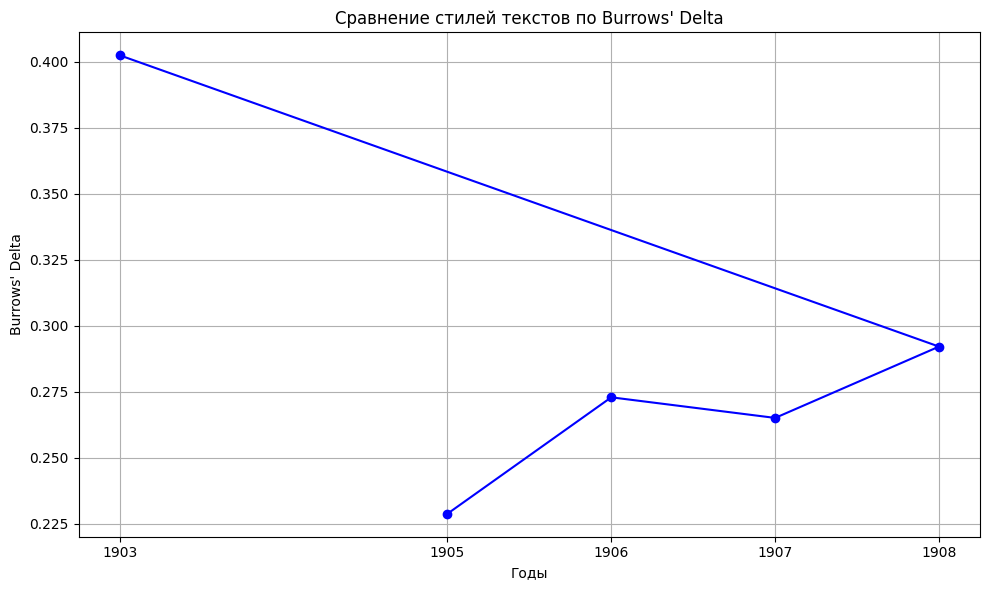

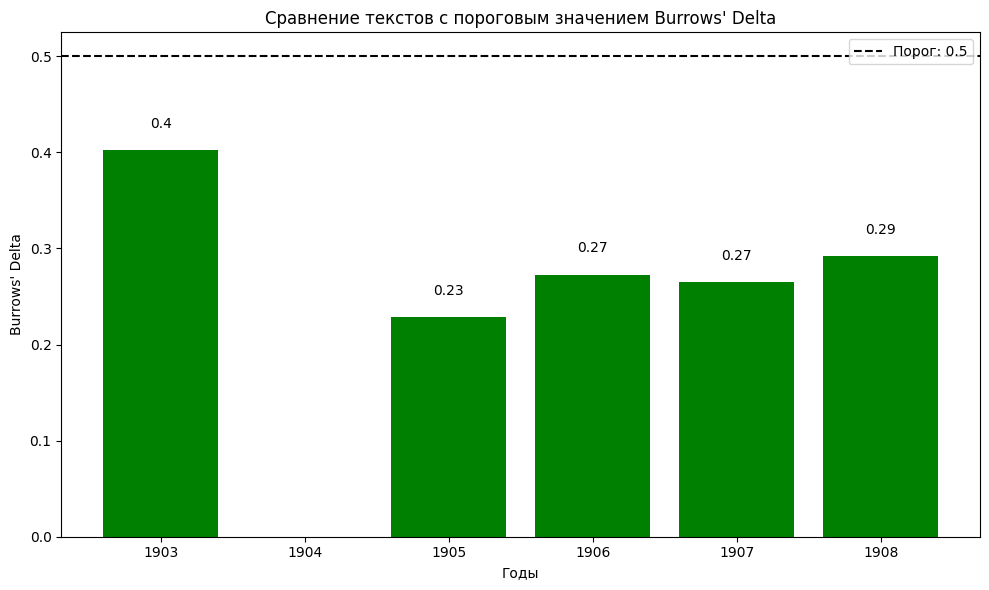

In [ ]:
# Данных
delta_scores = {
    1905: 0.2288,
    1906: 0.2729,
    1907: 0.2651,
    1908: 0.2921,
    1903: 0.4024
}

# Визуализация
visualize_all_data(delta_scores)

# **Burrows’ Delta**

Burrows’ Delta — это метод вычисления стилистической схожести текстов. Он используется в статистической стилистике, в том числе атрибуции авторства. Метрика основана на частотном анализе слов, где тексты сравниваются по их стилистическим характеристикам, таким как частота наиболее часто встречающихся слов.

*Если два текста имеют схожие частоты употребления определённых слов, то их стили похожи, что может указывать на общего автора.*

Как работает Burrows’ Delta

1.	Подготовка данных:
	* Каждый текст обрабатывается, чтобы выделить только значимые слова (обычно игнорируются стоп-слова, местоимения и т.п.).
	* Для каждого текста строится частотный профиль наиболее часто встречающихся слов.
2.	Создание стандартного частотного профиля:
	* Выбираются наиболее частотные слова для анализа (например, 100 самых популярных слов).
	* Для каждого слова вычисляется его средняя частота в текстах (среднее значение для всех текстов).
	* Рассчитывается стандартное отклонение частоты для каждого слова.
3.	Преобразование текстов в стандартизированные векторы:
	* Для каждого текста вычисляется Z-оценка (нормализация)
где:
	* — частота слова в тексте.
	* — средняя частота слова по всем текстам.
	* — стандартное отклонение частоты слова по всем текстам.
4.	Вычисление расстояния между текстами:
	* Для каждой пары текстов вычисляется среднеквадратичное отклонение (манхэттенское расстояние) между их Z-векторами:
  * — количество слов в частотном профиле.
5.	Результат:
	* Итогом является симметричная матрица, где каждая ячейка отражает расстояние Burrows’ Delta между текстами.

Интерпритация матрицы
1.	Малые значения (близкие к 0):
	* Указывают на высокую степень сходства текстов. Например, два текста одного автора.
2.	Большие значения:
	* Показывают, что тексты стилистически сильно отличаются. Например, тексты разных жанров или авторов.

Преимущества Burrows’ Delta:

  * Простота: Метод легко реализовать и интерпретировать.
	* Эффективность: Работает даже с короткими текстами.
	* Гибкость: Подходит для анализа текста на любом языке, если есть токенизатор и данные для анализа.
